# Building an image similarity system with 🤗 Datasets FAISS
- Ref: 
    - https://colab.research.google.com/gist/sayakpaul/5b5b5a9deabd3c5d8cb5ef8c7b4bb536/image_similarity_faiss.ipynb

## Configure device

In [1]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
    if torch.mps.driver_allocated_memory() - torch.mps.current_allocated_memory()< 1e4:
        print("Not enough mps memory, convert to cpu mode")
        t_device = torch.device("cpu")
        s_device = "cpu"
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(t_device)

cuda


### Load model for computing embeddings of the candidate images


In [2]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

/home/hyunjae/anaconda3/envs/hf_transformers/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load candidate subset

In [3]:
from datasets import load_dataset

seed = 42
num_samples = 100
dataset = load_dataset("beans", split="train")
candidate_dataset = dataset.shuffle(seed=seed).select(range(num_samples))

### Extract embeddings

In [4]:
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

In [5]:
dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})
dataset_with_embeddings.add_faiss_index(column='embeddings')

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image_file_path', 'image', 'labels', 'embeddings'],
    num_rows: 100
})

### Load test set for querying

In [6]:
test_ds = load_dataset("beans", split="test")

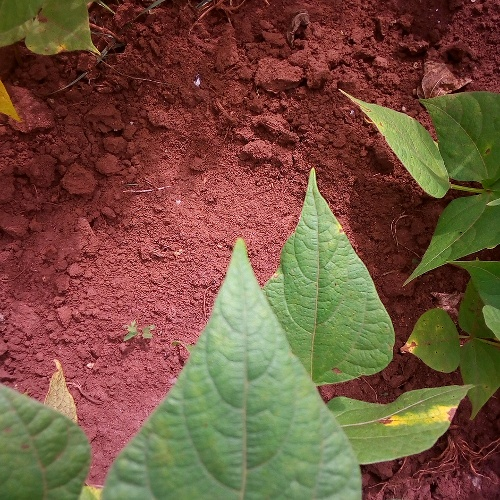

In [7]:
import numpy as np

random_index = np.random.choice(len(test_ds))
query_image = test_ds[random_index]["image"]
query_image

In [8]:
def get_neighbors(query_image, top_k=5):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples


scores, retrieved_examples = get_neighbors(query_image)



In [9]:
scores

array([10.118172, 10.147831, 10.68721 , 10.806389, 10.910947],
      dtype=float32)

In [10]:
retrieved_examples

{'image_file_path': ['/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/healthy/healthy_train.52.jpg',
  '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/healthy/healthy_train.24.jpg',
  '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/healthy/healthy_train.215.jpg',
  '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/healthy/healthy_train.254.jpg',
  '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/healthy/healthy_train.63.jpg'],
 'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
  <PI

In [11]:
# Reference: 
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion_jax_how_to.ipynb

from PIL import Image 


def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

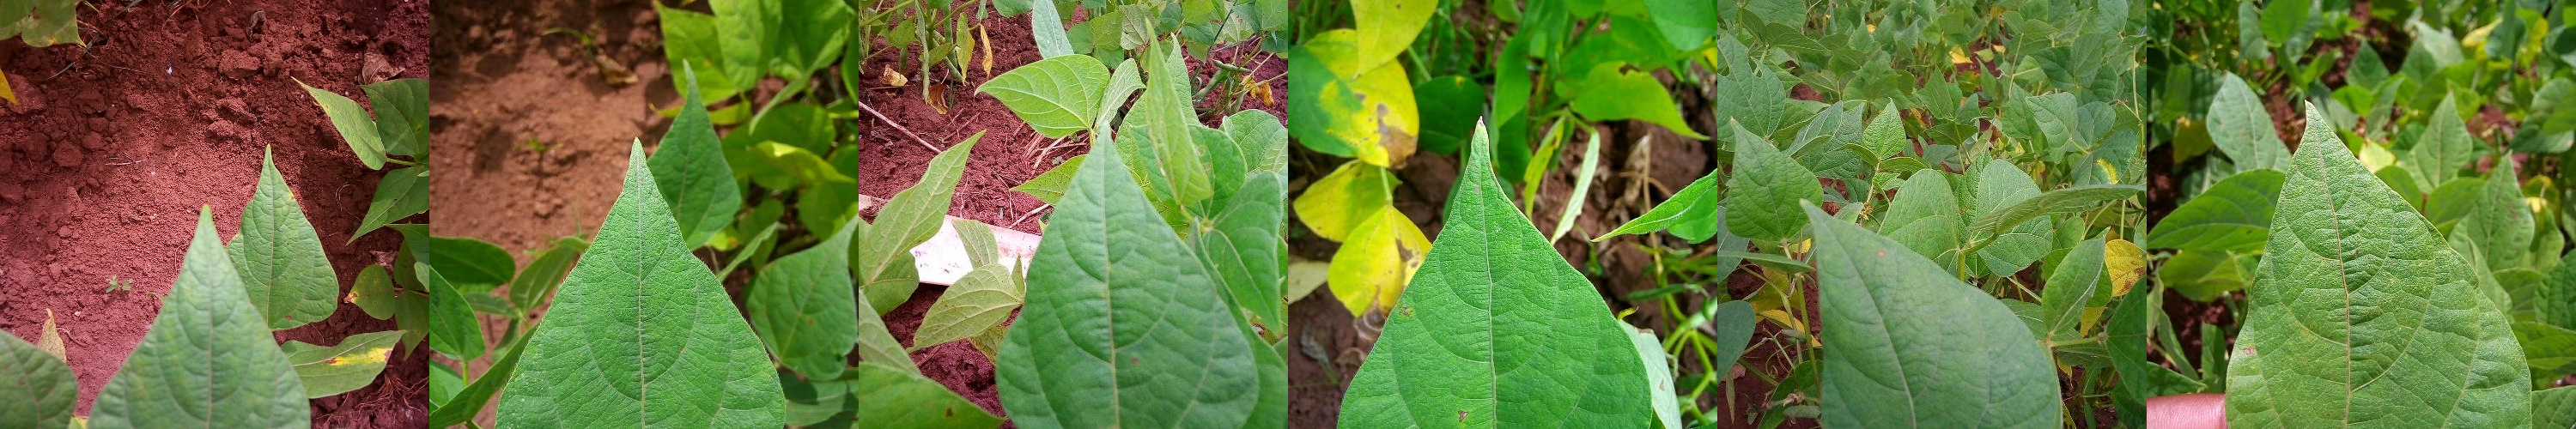

In [12]:
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 1, len(images))

In [13]:
print("Done")

Done
